## <u>This script does the following:</u>
<ol>
  <li>Input</li>
    <ol>
      <li>combining train and test cvs for consolidated transformation</li>
    </ol>     
  <li>Cleaning</li>
    <ol>
      <li>handling missing values</li>
      <li>One-hot encoding and rebucketing of categorical variables </li>
      <li>clipping outliers</li>
    </ol>   
  <li>EDA</li>
    <ol>
      <li>explore stationarity of resale price time series</li>
      <li>analyse residuals of feature for suitability in regression model</li>
      <li>explore multicolinearity between features</li>
      <li>explore catergorical features that impact resale price</li>
    </ol> 
  <li>Feature Selection</li>
    <ol>
      <li>low variance filter dimensionality reduction</li>
      <li>identify numeric fetures that correlate with resale price</li>
    </ol>
  <li>Output</li>
    <ol>
      <li>pickle prepped data</li>
    </ol>   
</ol>

## 1A. I/O: Input data

In [1]:
# import libraries
import os
import glob
import chardet
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import time

from sklearn.preprocessing import normalize
from statsmodels.stats.outliers_influence import variance_inflation_factor

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [2]:
df_append = pd.DataFrame()
path = "../datasets/t*.csv" 
for file in glob.glob(path):
    with open(file,'rb') as f:
        enc = chardet.detect(f.read())
    df_temp = pd.read_csv(file, encoding = enc['encoding']) # otherwise will have uft-8 error as is in ISO-8859-1 format
    df_temp = df_temp.rename(columns=str.lower) # columns names in different case between files
    df_temp['file']=file #get name of file
    df_append = pd.concat(objs =[df_append,df_temp],axis=0)

housing_df = df_append.sort_values(by=['id','tranc_yearmonth'],axis=0).reset_index(drop=True)

In [3]:
housing_df.head(5)

id tranc_yearmonth         town flat_type block         street_name storey_range  floor_area_sqm flat_model  lease_commence_date  tranc_year  tranc_month  mid_storey  lower  upper  mid   full_flat_type                address  floor_area_sqft  hdb_age  max_floor_lvl  year_completed residential commercial market_hawker multistorey_carpark precinct_pavilion  total_dwelling_units  1room_sold  2room_sold  3room_sold  4room_sold  5room_sold  exec_sold  multigen_sold  studio_apartment_sold  1room_rental  2room_rental  3room_rental  other_room_rental postal  latitude   longitude planning_area  mall_nearest_distance  mall_within_500m  mall_within_1km  mall_within_2km  hawker_nearest_distance  hawker_within_500m  hawker_within_1km  hawker_within_2km  hawker_food_stalls  hawker_market_stalls  mrt_nearest_distance     mrt_name  bus_interchange  mrt_interchange  mrt_latitude  mrt_longitude  bus_stop_nearest_distance bus_stop_name  bus_stop_latitude  bus_stop_longitude  \
0   1         2015-03  BUKIT MERAH    1 ROOM     7  TELOK BLANGAH CRES     07 TO 09            31.0   Improved                 1975        2015            3           8      7      9    8  1 ROOM Improved  7, TELOK BLANGAH CRES          333.684       46             12            1974           Y          N             N                   N                 N                   262         255           0           2           0           0          0              0                      0             5             0             0                  0  90007  1.278361  103.819384   Bukit Merah            1246.092272               NaN              NaN              5.0               125.006922                 1.0                5.0               14.0                  56                    77           1180.622358  Tiong Bahru                0                0      1.285765     103.826997                  99.027522        Blk 11           1.277845          103.818658   
1   2         2015-04  BUKIT MERAH    1 ROOM     7  TELOK BLANGAH CRES     01 TO 03            31.0   Improved                 1975        2015            4           2      1      3    2  1 ROOM Improved  7, TELOK BLANGAH CRES          333.684       46             12            1974           Y          N             N                   N                 N                   262         255           0           2           0           0          0              0                      0             5             0             0                  0  90007  1.278361  103.819384   Bukit Merah            1246.092272               NaN              NaN              5.0               125.006922                 1.0                5.0               14.0                  56                    77           1180.622358  Tiong Bahru                0                0      1.285765     103.826997                  99.027522        Blk 11           1.277845          103.818658   
2   3         2015-05  BUKIT MERAH    1 ROOM     7  TELOK BLANGAH CRES     01 TO 03            31.0   Improved                 1975        2015            5           2      1      3    2  1 ROOM Improved  7, TELOK BLANGAH CRES          333.684       46             12            1974           Y          N             N                   N                 N                   262         255           0           2           0           0          0              0                      0             5             0             0                  0  90007  1.278361  103.819384   Bukit Merah            1246.092272               NaN              NaN              5.0               125.006922                 1.0                5.0               14.0                  56                    77           1180.622358  Tiong Bahru                0                0      1.285765     103.826997                  99.027522        Blk 11           1.277845          103.818658   
3   4         2015-09  BUKIT MERAH    1 ROOM     7  TELOK BLANGAH CRES     01 TO 03            31.0

In [4]:
housing_df.describe(percentiles=[0.05,0.25,0.5,0.75,0.95])

id  floor_area_sqm  lease_commence_date     tranc_year    tranc_month     mid_storey          lower          upper            mid  floor_area_sqft        hdb_age  max_floor_lvl  year_completed  total_dwelling_units     1room_sold     2room_sold     3room_sold     4room_sold     5room_sold      exec_sold  multigen_sold  studio_apartment_sold   1room_rental   2room_rental   3room_rental  other_room_rental       latitude      longitude  mall_nearest_distance  mall_within_500m  mall_within_1km  mall_within_2km  hawker_nearest_distance  hawker_within_500m  hawker_within_1km  hawker_within_2km  hawker_food_stalls  hawker_market_stalls  mrt_nearest_distance  bus_interchange  mrt_interchange   mrt_latitude  mrt_longitude  bus_stop_nearest_distance  bus_stop_latitude  bus_stop_longitude  pri_sch_nearest_distance        vacancy  pri_sch_affiliation  pri_sch_latitude  pri_sch_longitude  sec_sch_nearest_dist   cutoff_point    affiliation  sec_sch_latitude  sec_sch_longitude  \
count  167371.000000   167371.000000        167371.000000  167371.000000  167371.000000  167371.000000  167371.000000  167371.000000  167371.000000    167371.000000  167371.000000  167371.000000   167371.000000         167371.000000  167371.000000  167371.000000  167371.000000  167371.000000  167371.000000  167371.000000  167371.000000          167371.000000  167371.000000  167371.000000  167371.000000      167371.000000  167371.000000  167371.000000          166458.000000      64290.000000     139159.00000    165218.000000            167371.000000        59226.000000       99774.000000      134915.000000       167371.000000         167371.000000         167371.000000    167371.000000    167371.000000  167371.000000  167371.000000              167371.000000      167371.000000       167371.000000             167371.000000  167371.000000        167371.000000     167371.000000      167371.000000         167371.000000  167371.000000  167371.000000     167371.000000      167371.000000   
mean    92968.475955       97.170249          1992.437740    2016.486853       6.579581       8.283980       7.247307       9.320653       8.283980      1045.940564      28.562260      15.138835     1990.911078            124.692719       0.135597       1.792784      39.234933      50.148825      26.263612       5.908359       0.024395               0.444653       0.064641       0.615423       0.059186           0.000311       1.366199     103.839433             663.965693          1.269000          2.15031         5.235713              1173.403598            1.383058           2.361387           4.710173           48.639143             58.103387            765.185157         0.547448         0.264132       1.365640     103.839437                 115.208512           1.366206          103.839411                395.167676      55.367292             0.113138          1.366243         103.839147            508.775911     210.146453       0.032061          1.365961         103.839377   
std     53642.610044       24.407577            12.142045       2.751701       3.344801       5.507645       5.514843       5.506856       5.507645       262.723162      12.142045       6.221926       12.206586             58.325918       5.878694      11.762149      68.756973      45.345023      33.419381      19.085181       1.146541               5.318508       2.073149      11.079283       0.669497           0.023187       0.042843       0.072468             368.593335          0.625958          1.28859         3.451053              1076.928191            0.651919           1.631056           3.959728           19.115889             55.450808            429.512478         0.497745         0.440871       0.042555       0.072541                  55.587557           0.042857            0.072481                234.717851      17.902748             0.316762          0.042658           0.072598            309.437332      20.014457       0.176161          0.042592           0.072593   
min         1.000000      

In [5]:
housing_df['file'].value_counts()

../datasets/train.csv    150634
../datasets/test.csv      16737
Name: file, dtype: int64

In [6]:
# set index for easier manipulation
housing_df.set_index('id', inplace=True)

In [7]:
# prevent mixed datatypes in any column
for i in list(housing_df.select_dtypes(include='object').columns):
    housing_df[i]=housing_df[i].map(lambda x: str(x))

## 2A. Handling missing data

In [8]:
housing_df.isnull().sum()

tranc_yearmonth                   0
town                              0
flat_type                         0
block                             0
street_name                       0
storey_range                      0
floor_area_sqm                    0
flat_model                        0
lease_commence_date               0
tranc_year                        0
tranc_month                       0
mid_storey                        0
lower                             0
upper                             0
mid                               0
full_flat_type                    0
address                           0
floor_area_sqft                   0
hdb_age                           0
max_floor_lvl                     0
year_completed                    0
residential                       0
commercial                        0
market_hawker                     0
multistorey_carpark               0
precinct_pavilion                 0
total_dwelling_units              0
1room_sold                  

In [9]:
# replace those missing with 0
col_list=['mall_within_500m','mall_within_1km','mall_within_2km',
          'hawker_within_500m','hawker_within_1km', 'hawker_within_2km']
for col in col_list:
    housing_df[col] = housing_df[col].fillna(0)

In [10]:
#for missing mall nearest distance replace with the mean distance in district
# map postal codes to housing district zones based on 2d postal code
# change length to 6 if 5
housing_df['postal']=housing_df['postal'].astype(str)
housing_df['postal']=housing_df['postal'].str.zfill(6)
housing_df.insert(42, 'postal_2d', housing_df['postal'].str.slice(0, 2))
# NIL postal code: encode postal_2d to SENGKANG -> 54, CHOA CHU KANG -> 67
housing_df.loc[((housing_df['postal_2d']=='00') &  (housing_df['town']=='SENGKANG')),'postal_2d']='54'
housing_df.loc[((housing_df['postal_2d']=='00') &  (housing_df['town']=='CHOA CHU KANG')),'postal_2d']='67'
#housing_df['postal_2d'].value_counts()

map_from=['01','02','03','04','05','06','07','08','09','10',
         '11','12','13','14','15','16','17','18','19','20',
         '21','22','23','24','25','26','27','28','29','30',
         '31','32','33','34','35','36','37','38','39','40',
         '41','42','43','44','45','46','47','48','49','50',
         '51','52','53','54','55','56','57','58','59','60',
         '61','62','63','64','65','66','67','68','69','70',
         '71','72','73','74','75','76','77','78','79','80',
         '81','82']

map_to=[1,1,1,1,1,1,2,2,4,4,
        5,5,5,3,3,3,6,7,7,8,
        8,9,9,10,10,10,10,11,11,11,
        12,12,12,13,13,13,13,14,14,14,
        14,15,15,15,15,16,16,16,17,17,
        18,18,19,19,19,20,20,21,21,22,
        22,22,22,22,23,23,23,23,24,24,
        24,25,25,'74',27,27,26,26,28,28,
       17,19]

housing_df.insert(43, 'district_num', housing_df['postal_2d'].replace(map_from,map_to))
#housing_df['district_num'].value_counts()

for district in range(1,28+1):
    mean_value=int(housing_df[housing_df['district_num']==19]['mall_nearest_distance'].mean())
    housing_df.loc[((housing_df['district_num']==district) & (housing_df['mall_nearest_distance'].isna())),'mall_nearest_distance']=mean_value

housing_df.isnull().sum()

## 2B. One-hot encoding and rebucketing of categorical variables 

In [11]:
# OHE of Y/N to 1/0
col_list=['residential','commercial','market_hawker','multistorey_carpark','precinct_pavilion']
for col in col_list:
    housing_df=housing_df.replace({col:{'Y': 1,'N': 0}})

In [12]:
housing_df['central']=housing_df['district_num'].apply(lambda x: 1 if x<=11 
                                                      else 0)

housing_df['levels']=housing_df['mid_storey'].apply(lambda x: "0-5" if x<=5 
                                        else "6-10" if x <=10
                                       else "11-15" if x<=15
                                       else "16-20" if x<=20
                                       else "21-30" if x<=30
                                       else "31-40" if x<=40
                                       else "40-50")

In [13]:
housing_df['flat_model'].unique()

array(['Improved', 'Adjoined flat', 'Standard', 'Premium Apartment',
       'Model A', '2-room', 'New Generation', 'DBSS', 'Simplified',
       'Terrace', 'Model A-Maisonette', 'Improved-Maisonette',
       'Apartment', 'Multi Generation', 'Premium Apartment Loft',
       'Model A2', 'Type S1', 'Type S2', 'Premium Maisonette',
       'Maisonette'], dtype=object)

In [14]:
housing_df['a']=1

In [15]:
table = pd.pivot_table(housing_df, values='a', index='flat_model', columns='flat_type', aggfunc=np.sum)
table

flat_type               1 ROOM  2 ROOM   3 ROOM   4 ROOM   5 ROOM  EXECUTIVE  MULTI-GENERATION
flat_model                                                                                    
2-room                     NaN     4.0      NaN      NaN      NaN        NaN               NaN
Adjoined flat              NaN     NaN      NaN     31.0    156.0      103.0               NaN
Apartment                  NaN     NaN      NaN      NaN      NaN     6726.0               NaN
DBSS                       NaN     1.0    204.0    649.0    954.0        NaN               NaN
Improved                  89.0   583.0  11390.0   2066.0  28587.0        NaN               NaN
Improved-Maisonette        NaN     NaN      NaN      NaN     21.0        NaN               NaN
Maisonette                 NaN     NaN      NaN      NaN      NaN     4817.0               NaN
Model A                    NaN   819.0   9400.0  39087.0   2194.0        NaN               NaN
Model A-Maisonette         NaN     NaN      NaN      NaN    291.0        NaN               NaN
Model A2                   NaN     NaN      NaN   2322.0      NaN        NaN               NaN
Multi Generation           NaN     NaN      NaN      NaN      NaN        NaN              64.0
New Generation             NaN     NaN  16885.0   9033.0      NaN        NaN               NaN
Premium Apartment          NaN    45.0    474.0   8522.0   6176.0     1590.0               NaN
Premium Apartment Loft     NaN     NaN      NaN     38.0     16.0        NaN               NaN
Premium Maisonette         NaN     NaN      NaN      NaN      NaN       17.0               NaN
Simplified                 NaN     NaN   2167.0   5901.0      NaN        NaN               NaN
Standard                   NaN   679.0   2808.0     74.0   1873.0        NaN               NaN
Terrace                    NaN     NaN     96.0      9.0      NaN        NaN               NaN
Type S1                    NaN     NaN      NaN    271.0      NaN        NaN               NaN
Type S2                    NaN     NaN      NaN      NaN    139.0        NaN               NaN

In [16]:
# Re-categorize flat model to reduce num classes
replace_values = {'Improved':'Standard','Adjoined flat':'Special','Premium Apartment':'Premium',
                  'Model A':'Standard','2-room':'Standard','New Generation':'Standard','DBSS':'Special','Simplified':'Standard',
                  'Terrace':'Special','Model A-Maisonette':'Maisonette','Improved-Maisonette':'Maisonette',
                  'Apartment':'Standard','Multi Generation':'Special','Premium Apartment Loft':'Premium',
                  'Model A2':'Standard','Type S1':'Special','Type S2':'Special','Premium Maisonette':'Maisonette'}
    
housing_df = housing_df.replace({'flat_model': replace_values})

In [17]:
housing_df.groupby('flat_model').agg({'resale_price': ['min', 'max', 'median','count']})

resale_price                             
                    min        max    median   count
flat_model                                          
Maisonette     425000.0  1210000.0  655000.0    4660
Premium        205000.0  1138888.0  468000.0   15141
Special        300000.0  1258000.0  780000.0    2438
Standard       150000.0  1200000.0  408000.0  128395

In [18]:
# reduce number of class of town to regions
d_region = {'ANG MO KIO':'North East', 'BEDOK':'East', 'BISHAN':'Central', 'BUKIT BATOK':'West', 'BUKIT MERAH':'Central',
       'BUKIT PANJANG':'West', 'BUKIT TIMAH':'Central', 'CENTRAL AREA':'Central', 'CHOA CHU KANG':'West',
       'CLEMENTI':'West', 'GEYLANG':'Central', 'HOUGANG':'North East', 'JURONG EAST':'West', 'JURONG WEST':'West',
       'KALLANG/WHAMPOA':'Central', 'MARINE PARADE':'Central', 'PASIR RIS':'East', 'PUNGGOL':'North East',
       'QUEENSTOWN':'Central', 'SEMBAWANG':'North', 'SENGKANG':'North East', 'SERANGOON':'North East', 'TAMPINES':'East',
       'TOA PAYOH':'Central', 'WOODLANDS':'North', 'YISHUN':'North'}
housing_df['region'] = housing_df['town'].map(d_region)

In [19]:
housing_df.groupby('region').agg({'resale_price': ['min', 'max', 'median','count']})

resale_price                            
                    min        max    median  count
region                                             
Central        150000.0  1258000.0  490000.0  28566
East           180000.0   935000.0  440000.0  24315
North          170000.0   868000.0  380000.0  25099
North East     170000.0  1030000.0  438000.0  36448
West           175000.0  1095000.0  405000.0  36206

## 2C. Clipping outliers

In [20]:
numeric_feat =[col for col in housing_df.columns if housing_df[col].dtypes != 'O' and col not in ['id']]
discrete_feat = [col for col in numeric_feat if len(housing_df[col].unique())<25 and col not in ['id']]
continuous_feat = [col for col in numeric_feat if col not in discrete_feat]
categorical_feat = [col for col in housing_df.columns if housing_df[col].dtypes == 'O']

In [21]:
for j in range(len(continuous_feat)):
    var=continuous_feat[j]
    transformed="clipped_"+var
    upper_limit=housing_df[var].quantile(0.95)
    lower_limit=housing_df[var].quantile(0.05)
    housing_df[transformed]=housing_df[var].clip(lower_limit,upper_limit,axis=0)

## 3A. EDA - time series stationarity

<AxesSubplot: xlabel='date_ym', ylabel='resale_price'>

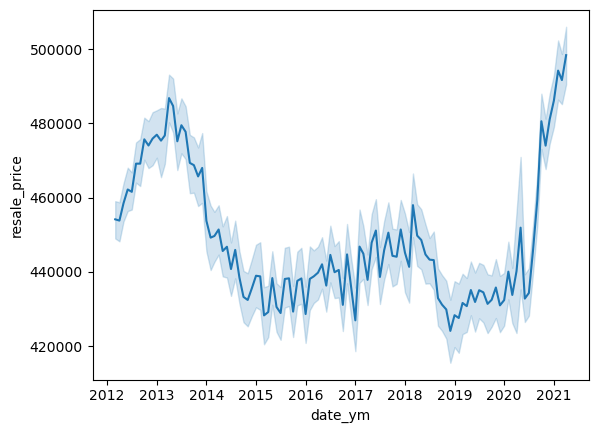

In [22]:
housing_df.insert(1, 'date_ym', pd.to_datetime(housing_df['tranc_yearmonth'], format='%Y-%m'))
sns.lineplot(data=housing_df, x="date_ym", y="resale_price")

In [23]:
ts_df=housing_df[["date_ym","resale_price"]]
ts_df.set_index('date_ym', inplace=True)

ts_df['resale_price']=np.log(ts_df['resale_price'])
ts_df=ts_df.dropna()

result=adfuller(ts_df)
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value)) 

Test Statistic: -18.161402
p-value: 0.000000
Critical values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


From line chart, we see that housing prices have changed over time, with a boom in 2013, suppressed pricing from 2014-2020, and a significant increase from 2021 onwards surpassing previous high. Therefore resale price is not stationary. 

Applying log transformation, the ADF test statics is lesser (more negative) then the critical value, and p-value is less than 0.05. Therefore we can reject null hypothesis. This indicates that the log transformation of resale price makes it stationary.    

In [24]:
housing_df['log_resale_price'] = np.log(housing_df['resale_price'])

## 3B. EDA -  distribution
#### find features with random pattern residual distribution, indicating a good fit for a linear model.

In [25]:
train_df = housing_df[housing_df['file']=='../datasets/train.csv'].drop(columns='file').copy(deep=True)
test_df = housing_df[housing_df['file']=='../datasets/test.csv'].drop(columns='file').copy(deep=True)

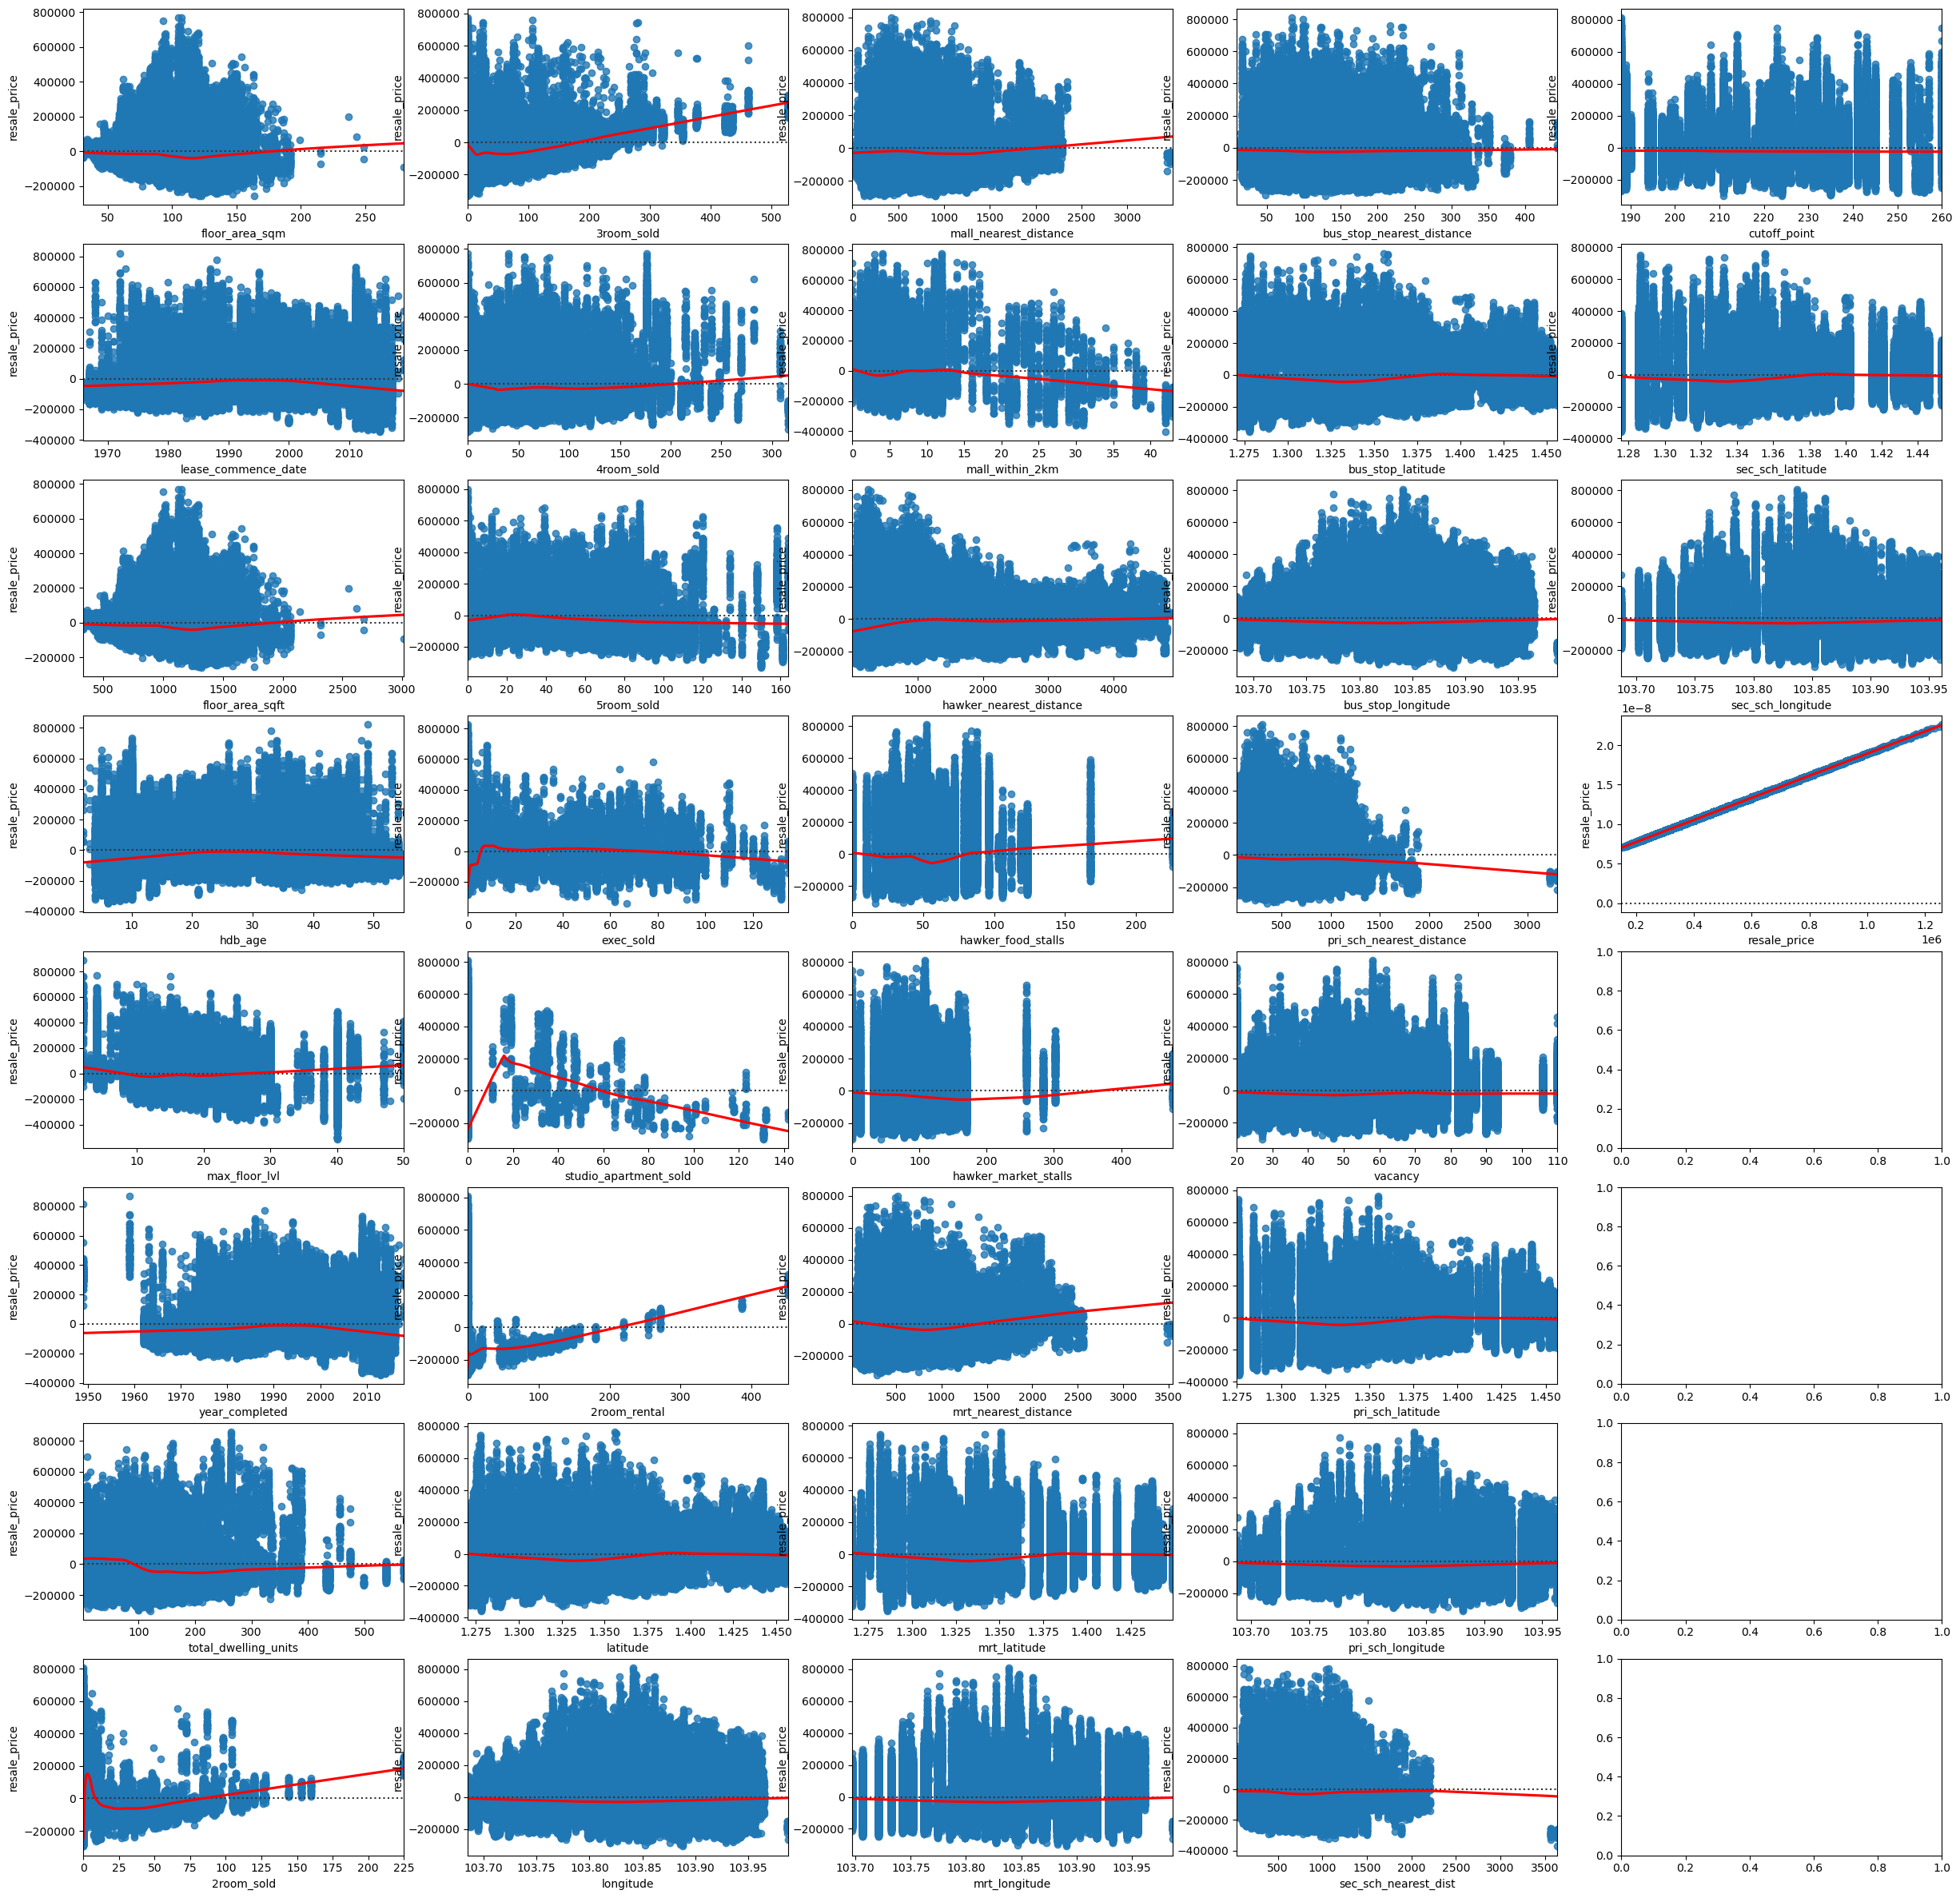

In [26]:
cols = 5
rows = int(len(continuous_feat)/cols+1)

# Scatter plot with regression line
f, axes = plt.subplots(rows, cols , figsize=(30, 30), sharex=False)
for i, feature in enumerate(continuous_feat):
    sns.residplot(data=train_df, x=feature, y='resale_price', lowess=True, line_kws=dict(color="r"), ax=axes[i%rows, i//rows]) 
plt.show()

residuals of continuous feature: 2room_sold, 3room_sold, studio_apartment_sold, 2room_rental do not appear to be normally distributed. May not be good fit for linear regression model without transformation.

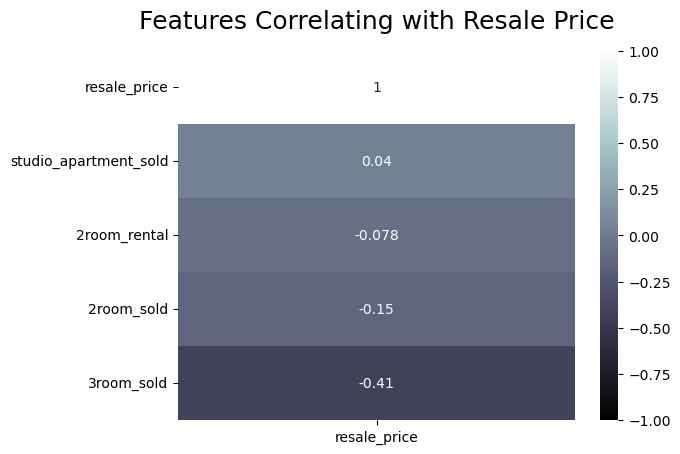

In [27]:
num_subset=train_df[['2room_sold','3room_sold','studio_apartment_sold','2room_rental','resale_price']]
heatmap = sns.heatmap(num_subset.corr(method='pearson',numeric_only=True)[['resale_price']].sort_values(by='resale_price', ascending=False), 
                      vmin=-1, vmax=1, annot=True, cmap='bone')
heatmap.set_title('Features Correlating with Resale Price', fontdict={'fontsize':18}, pad=16);

Besides 3room_sold the other features have low correlation to resale price, may be okay to drop. Drop 3room_sold too as correlation may not necestiate causation, not intuitive why sale of 3 room will negatively affect resale price

## 3C. EDA - collinarity of features

Text(0.5, 1.0, 'Feature Correlation Heatmap')

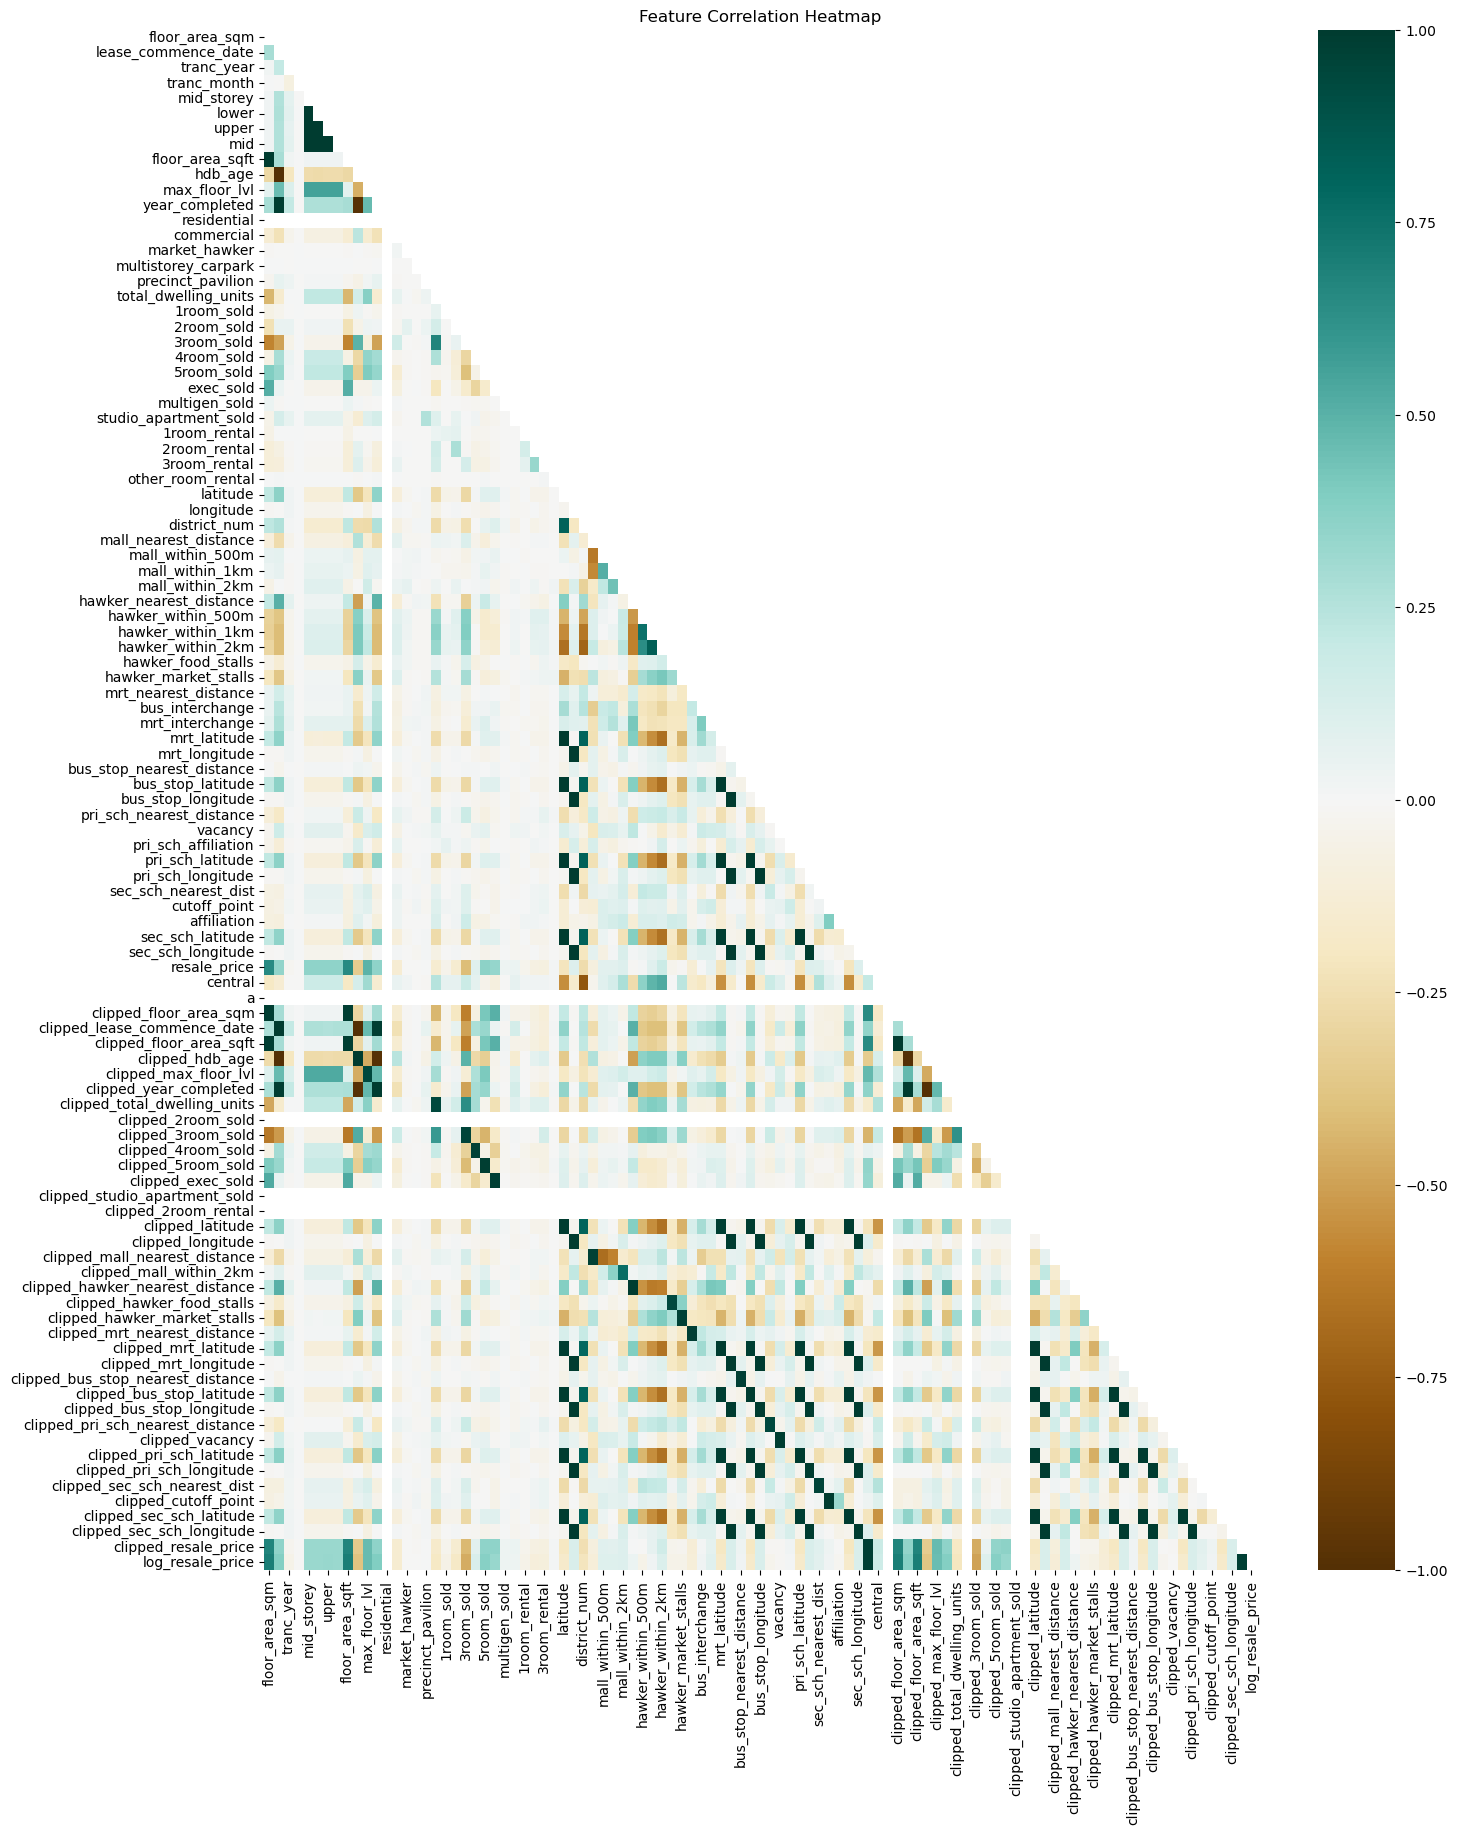

In [28]:
plt.figure(figsize=(16, 20))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(train_df.corr(), dtype=np.bool))
heatmap = sns.heatmap(train_df.corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('Feature Correlation Heatmap')

In [29]:
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['meanVIF'] = vif.VIF.mean()
    return(vif)

In [30]:
calc_vif(housing_df[['mid','upper','lower','mid_storey','max_floor_lvl']])

variables           VIF     tolerance        meanVIF
0            mid  2.664199e+03  3.753474e-04  383530.802694
1          upper  1.370879e+06  7.294591e-07  383530.802694
2          lower  4.213142e+05  2.373525e-06  383530.802694
3     mid_storey  1.227878e+05  8.144129e-06  383530.802694
4  max_floor_lvl  8.899958e+00  1.123601e-01  383530.802694

expected muliti-correlation between similar features: eg. lower, upper, mid, mid_storey. to select 1 of each of such groups

## 3D. EDA - relation of categorical features and price

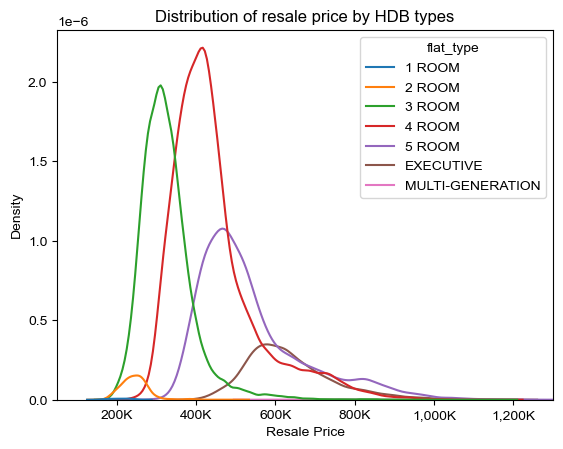

In [31]:
fig, ax = plt.subplots()
                   
sns.kdeplot(data=train_df, x="resale_price", hue="flat_type")
sns.set(rc={'figure.figsize': (7, 7)})
plt.title("Distribution of resale price by HDB types")
plt.xlabel("Resale Price")
ax.set_xlim(50000,1300000)
xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000]                       
ax.set_xticklabels(xlabels)
plt.show()

In [32]:
housing_df.groupby('flat_type').agg({'resale_price': ['min', 'max', 'median','count']})

resale_price                            
                          min        max    median  count
flat_type                                                
1 ROOM               157000.0   257000.0  209000.0     82
2 ROOM               150000.0   510000.0  245000.0   1896
3 ROOM               170000.0  1185000.0  318000.0  39060
4 ROOM               218000.0  1186888.0  420000.0  61136
5 ROOM               270000.0  1258000.0  500000.0  36415
EXECUTIVE            390000.0  1210000.0  615000.0  11989
MULTI-GENERATION     600000.0   980000.0  765500.0     56

Median resale price increase across different flat types

In [33]:
housing_df.head()

tranc_yearmonth    date_ym         town flat_type block         street_name storey_range  floor_area_sqm flat_model  lease_commence_date  tranc_year  tranc_month  mid_storey  lower  upper  mid   full_flat_type                address  floor_area_sqft  hdb_age  max_floor_lvl  year_completed  residential  commercial  market_hawker  multistorey_carpark  precinct_pavilion  total_dwelling_units  1room_sold  2room_sold  3room_sold  4room_sold  5room_sold  exec_sold  multigen_sold  studio_apartment_sold  1room_rental  2room_rental  3room_rental  other_room_rental  postal  latitude   longitude postal_2d  district_num planning_area  mall_nearest_distance  mall_within_500m  mall_within_1km  mall_within_2km  hawker_nearest_distance  hawker_within_500m  hawker_within_1km  hawker_within_2km  hawker_food_stalls  hawker_market_stalls  mrt_nearest_distance     mrt_name  bus_interchange  mrt_interchange  mrt_latitude  mrt_longitude  bus_stop_nearest_distance bus_stop_name  bus_stop_latitude  \
id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1          2015-03 2015-03-01  BUKIT MERAH    1 ROOM     7  TELOK BLANGAH CRES     07 TO 09            31.0   Standard                 1975        2015            3           8      7      9    8  1 ROOM Improved  7, TELOK BLANGAH CRES          333.684       46             12            1974            1           0              0                    0                  0                   262         255           0           2           0           0          0              0                      0             5             0             0                  0  090007  1.278361  103.819384        09             4   Bukit Merah            1246.092272               0.0              0.0              5.0               125.006922                 1.0                5.0               14.0                  56                    77           1180.622358  Tiong Bahru                0                0      1.285765     103.826997                  99.027522        Blk 11           1.277845   
2          2015-04 2015-04-01  BUKIT MERAH    1 ROOM     7  TELOK BLANGAH CRES     01 TO 03            31.0   Standard                 1975        2015            4           2      1      3    2  1 ROOM Improved  7, TELOK BLANGAH CRES          333.684       46             12            1974            1           0              0                    0                  0                   262         255           0           2           0           0          0              0                      0             5             0             0                  0  090007  1.278361  103.819384        09             4   Bukit Merah            1246.092272               0.0              0.0              5.0               125.006922                 1.0                5.0               14.0                  56                    77           1180.622358  Tiong Bahru                0                0      1.285765     103.826997                  99.027522        Blk 11           1.277845   
3          2015-05 2015-05-

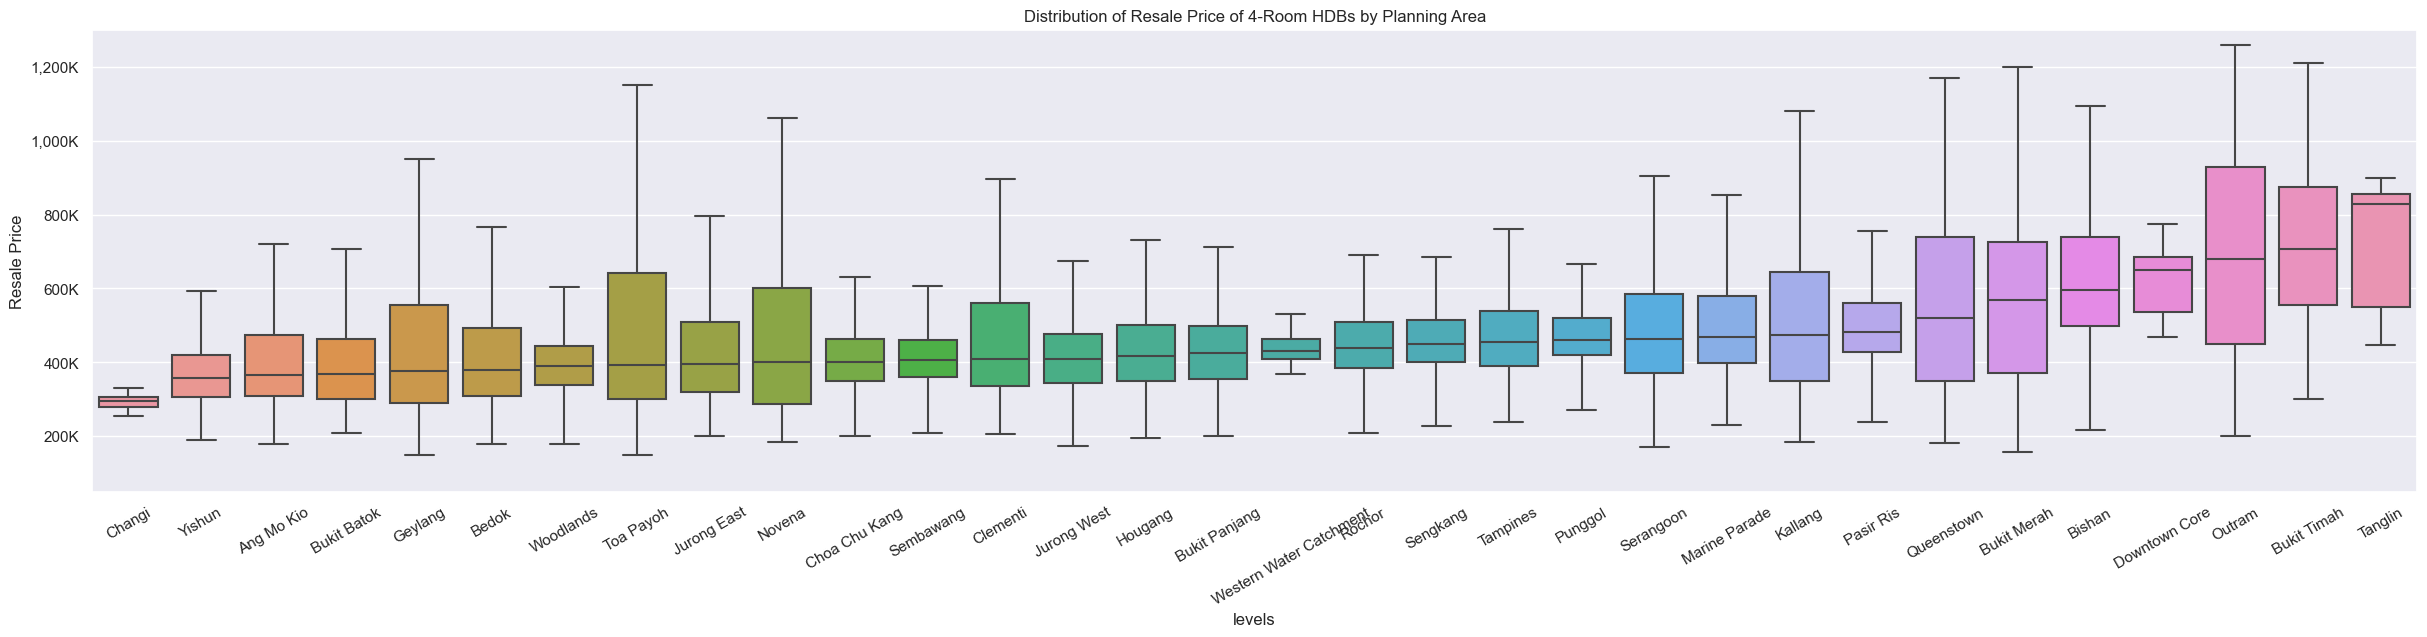

In [34]:
grouped = train_df.groupby('planning_area')
sorted_index = (
    pd.DataFrame({col: vals['resale_price'] for col, vals in grouped})
    .median()
    .sort_values(ascending=True)
)
fig, ax = plt.subplots(figsize=(30,6))
sns.boxplot(data=train_df, y='resale_price', x='planning_area', order=sorted_index.index, 
            showfliers = False)
sns.set(rc={'figure.figsize': (7, 7)})
plt.title("Distribution of Resale Price of 4-Room HDBs by Planning Area")
plt.xlabel("levels")
plt.ylabel("Resale Price")
ax.set_ylim(50000,1300000)
ylabels = ['{:,.0f}'.format(y) + 'K' for y in ax.get_yticks()/1000]                       
ax.set_yticklabels(ylabels)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

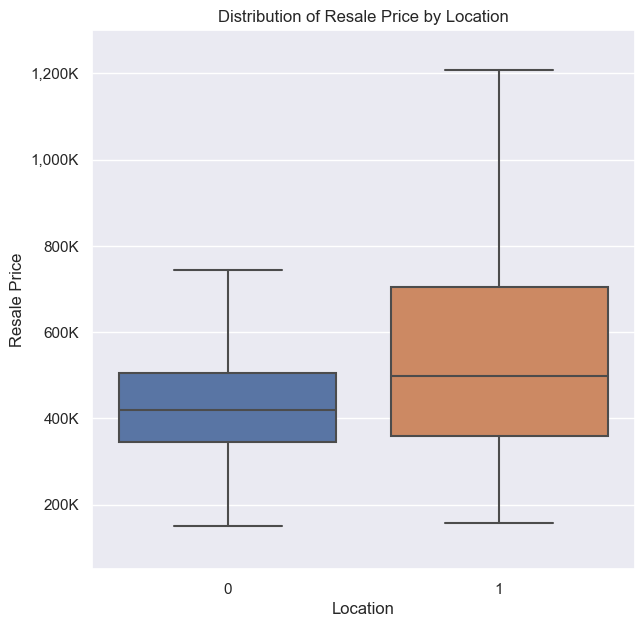

In [35]:
fig, ax = plt.subplots()
sns.boxplot(data=train_df, y='resale_price', x='central',showfliers = False)
sns.set(rc={'figure.figsize': (7, 7)})
plt.title("Distribution of Resale Price by Location")
plt.xlabel("Location")
plt.ylabel("Resale Price")
ax.set_ylim(50000,1300000)
ylabels = ['{:,.0f}'.format(y) + 'K' for y in ax.get_yticks()/1000]                       
ax.set_yticklabels(ylabels)
plt.show()

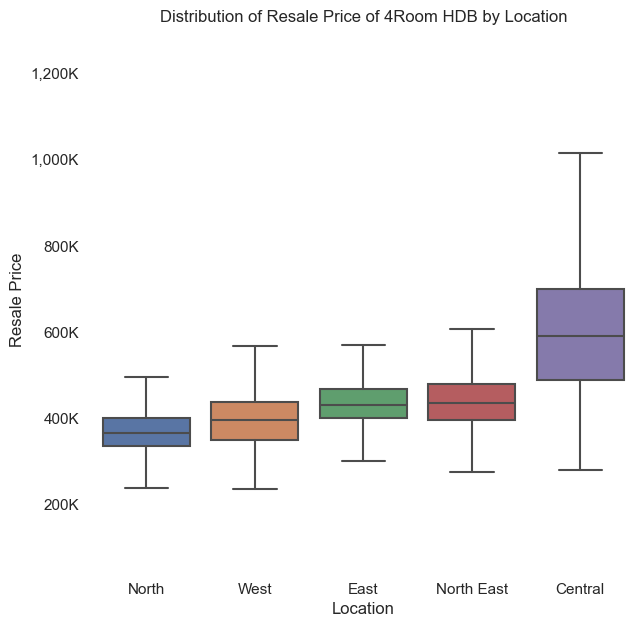

In [36]:
data=train_df[(train_df['flat_type']=='4 ROOM')]

grouped = data.groupby('region')
sorted_index = (
    pd.DataFrame({col: vals['resale_price'] for col, vals in grouped})
    .median()
    .sort_values(ascending=True)
)

fig, ax = plt.subplots()
ax.grid(False)
ax.set_facecolor('white')
sns.boxplot(data=data, y='resale_price', x='region',order=sorted_index.index, showfliers = False)
sns.set(rc={'figure.figsize': (7, 7)})
plt.title("Distribution of Resale Price of 4Room HDB by Location")
plt.xlabel("Location")
plt.ylabel("Resale Price")
ax.set_ylim(50000,1300000)
ylabels = ['{:,.0f}'.format(y) + 'K' for y in ax.get_yticks()/1000]                       
ax.set_yticklabels(ylabels)
plt.show()

In [37]:
data.groupby('region').agg({'resale_price': ['median','count']})

resale_price       
                 median  count
region                        
Central        590000.0   9835
East           430000.0   9198
North          366800.0  11535
North East     435000.0  16152
West           395000.0  14416

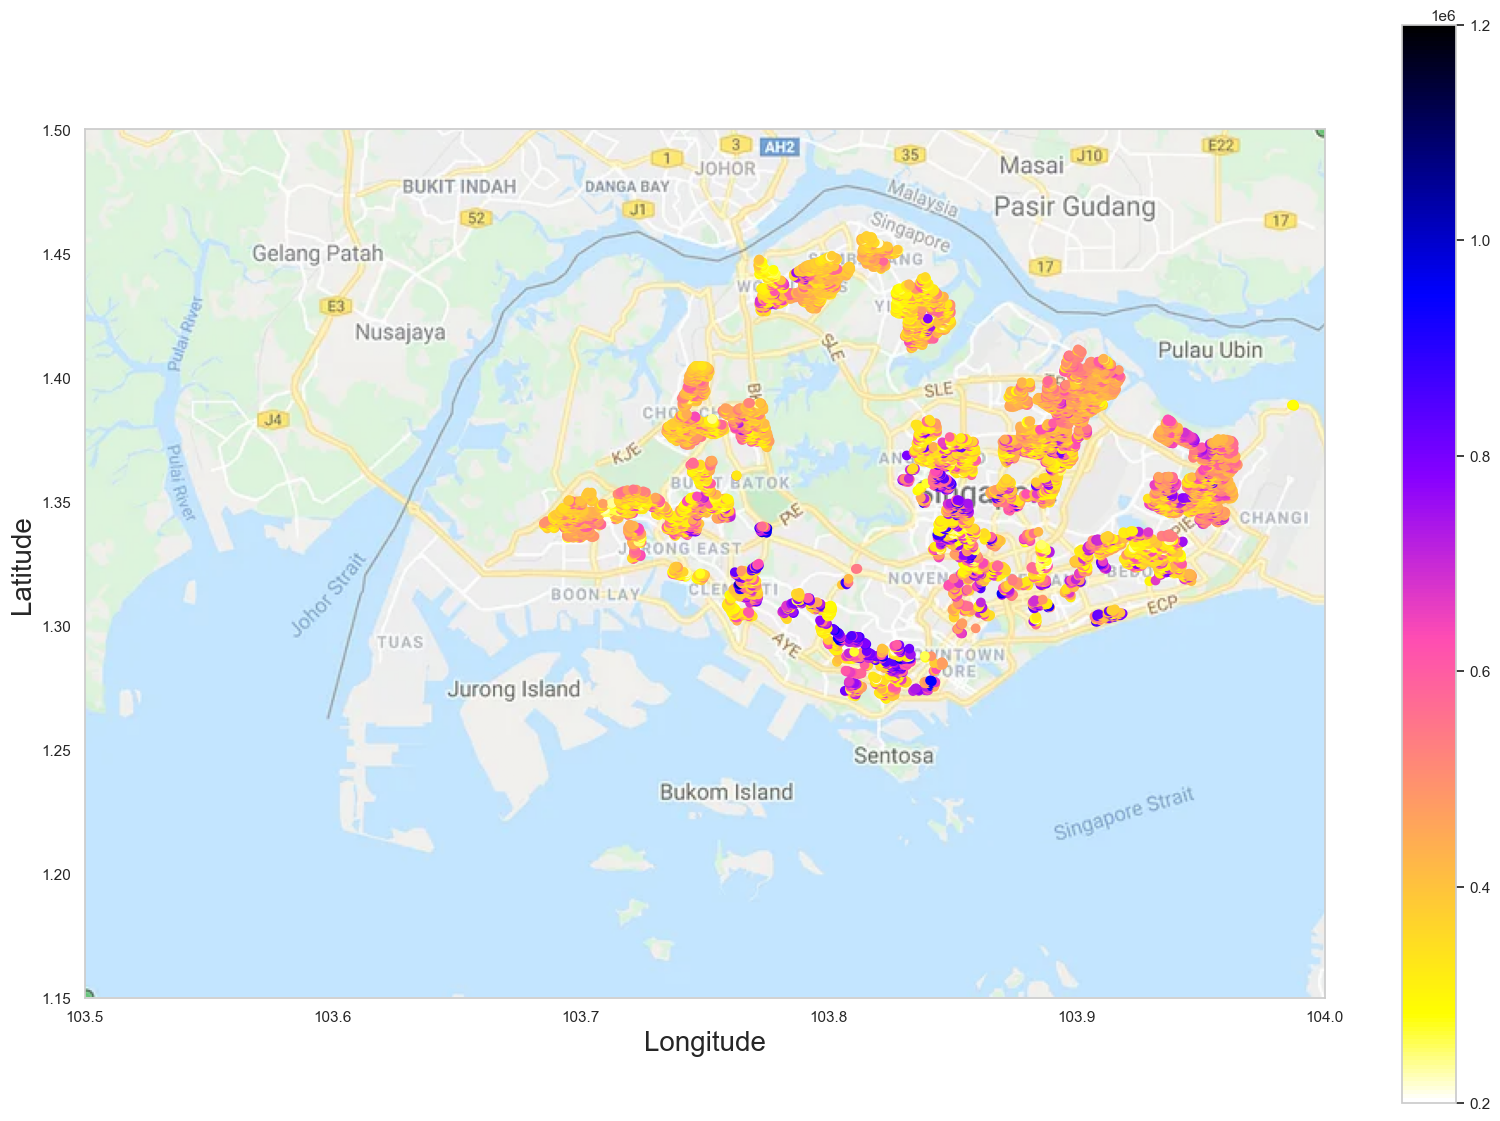

In [38]:
latlongprice = train_df.groupby(['latitude', 'longitude'])['resale_price'].median().reset_index()
import matplotlib.image as mpimg
singapore_img = mpimg.imread('../picture/sgmap.png')

sns.set(rc={'figure.figsize':(20,14)})
sns.set_style("whitegrid", {'axes.grid' : False})

plt.scatter(latlongprice['longitude'], latlongprice['latitude'], c=latlongprice['resale_price'],vmin=200000, vmax=1200000, cmap='gnuplot2_r')
plt.colorbar()
plt.imshow(singapore_img, extent=[103.5,104,1.15, 1.50], alpha=0.7)
plt.ylabel("Latitude", fontsize=20)
plt.xlabel("Longitude", fontsize=20)
# set the min/max axis values - these must be the same as above
plt.ylim(1.15, 1.50)
plt.xlim(103.5, 104)
plt.show()


Between central and outside central region, resale price differ

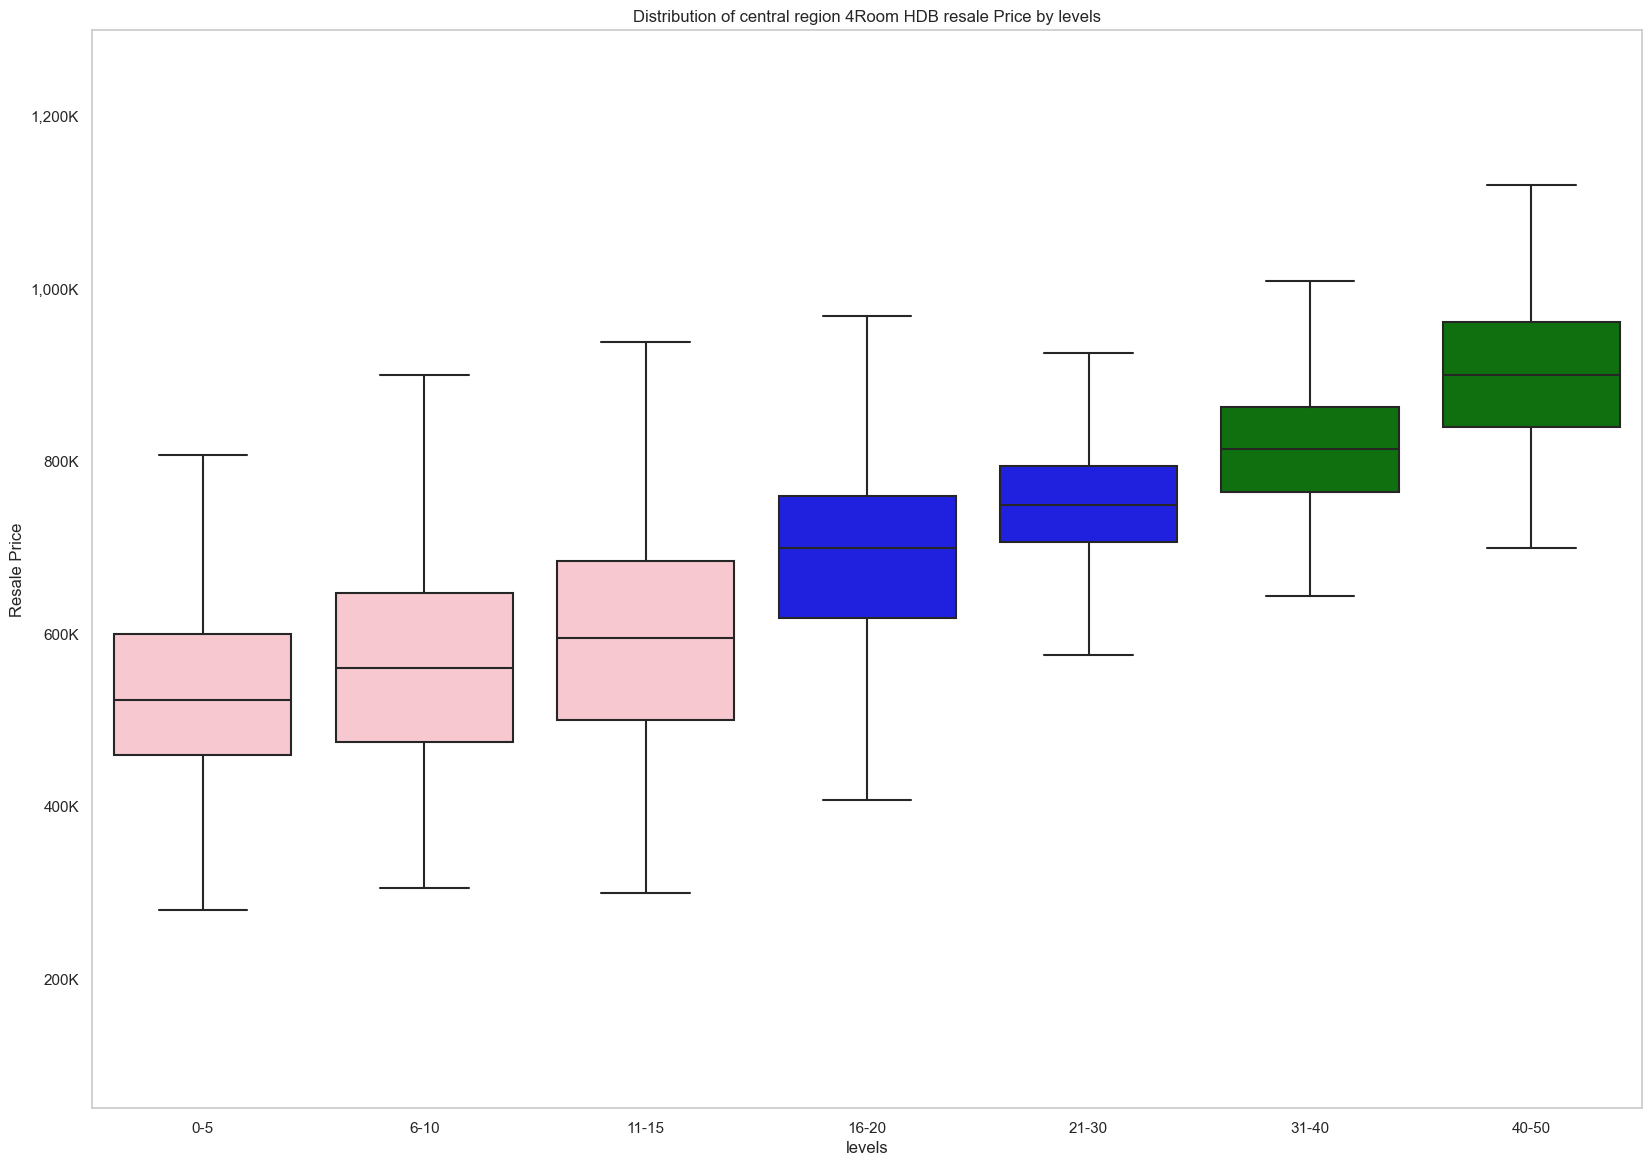

In [39]:
my_colors = {'0-5': 'pink',
             '6-10': 'pink',
             '11-15': 'pink',
             '16-20': 'blue',
             '21-30': 'blue',
             '31-40': 'green',
             '40-50': 'green'}
data=train_df[(train_df['flat_type']=='4 ROOM') & (train_df['region']=='Central')]

grouped = train_df.groupby('levels')
sorted_index = (
    pd.DataFrame({col: vals['mid_storey'] for col, vals in grouped})
    .mean()
    .sort_values(ascending=True)
)
fig, ax = plt.subplots()
ax.grid(False)
ax.set_facecolor('white')
sns.boxplot(data=data, y='resale_price', x='levels', order=sorted_index.index, 
            showfliers = False, palette=my_colors)
sns.set(rc={'figure.figsize': (3, 3)})
plt.title("Distribution of central region 4Room HDB resale Price by levels")
plt.xlabel("levels")
plt.ylabel("Resale Price")
ax.set_ylim(50000,1300000)
ylabels = ['{:,.0f}'.format(y) + 'K' for y in ax.get_yticks()/1000]                       
ax.set_yticklabels(ylabels)
plt.show()

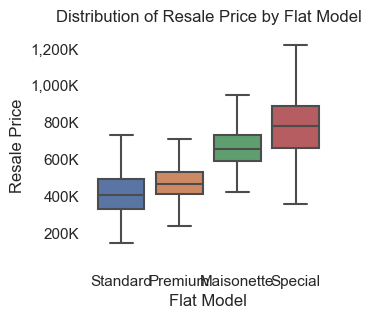

In [40]:
grouped = train_df.groupby('flat_model')
sorted_index = (
    pd.DataFrame({col: vals['resale_price'] for col, vals in grouped})
    .mean()
    .sort_values(ascending=True)
)

fig, ax = plt.subplots()
ax.grid(False)
ax.set_facecolor('white')
sns.boxplot(data=train_df, y='resale_price', x='flat_model', showfliers = False, order=sorted_index.index)
sns.set(rc={'figure.figsize': (7, 7)})
plt.title("Distribution of Resale Price by Flat Model")
plt.xlabel("Flat Model")
plt.ylabel("Resale Price")
ax.set_ylim(50000,1300000)
ylabels = ['{:,.0f}'.format(y) + 'K' for y in ax.get_yticks()/1000]                       
ax.set_yticklabels(ylabels)
plt.show()

In [41]:
data.groupby('levels').agg({'resale_price': ['median','count']})

resale_price      
             median count
levels                   
0-5        523000.0  3376
11-15      595000.0  2384
16-20      700000.0   994
21-30      750000.0   838
31-40      815000.0   364
40-50      900000.0    87
6-10       560000.0  1792

storey level matters holding flat type constant at 4 room and region constant at central region

## 4A. Feature Selection - Low variance filter dimensionality reduction

In [42]:
df=housing_df[numeric_feat].dropna()
data_scaled=normalize(df)
data_scaled=pd.DataFrame(data_scaled,columns=df.columns)
var=data_scaled.var()
var

floor_area_sqm               2.069882e-09
lease_commence_date          2.026499e-06
tranc_year                   2.121362e-06
tranc_month                  9.562773e-11
mid_storey                   1.358807e-10
lower                        1.335403e-10
upper                        1.396698e-10
mid                          1.358807e-10
floor_area_sqft              2.398242e-07
hdb_age                      2.058402e-09
max_floor_lvl                1.528593e-10
year_completed               2.022176e-06
residential                  5.209343e-13
commercial                   1.177804e-12
market_hawker                8.024345e-16
multistorey_carpark          2.001884e-15
precinct_pavilion            5.805405e-15
total_dwelling_units         4.376199e-08
1room_sold                   8.646366e-10
2room_sold                   1.919572e-09
3room_sold                   5.201145e-08
4room_sold                   1.122774e-08
5room_sold                   4.792490e-09
exec_sold                    1.049

longitude, latitude and amenity within x distance have low variability and may not value add to the model

## 4B. Feature Selection - higher correlated features to resale price

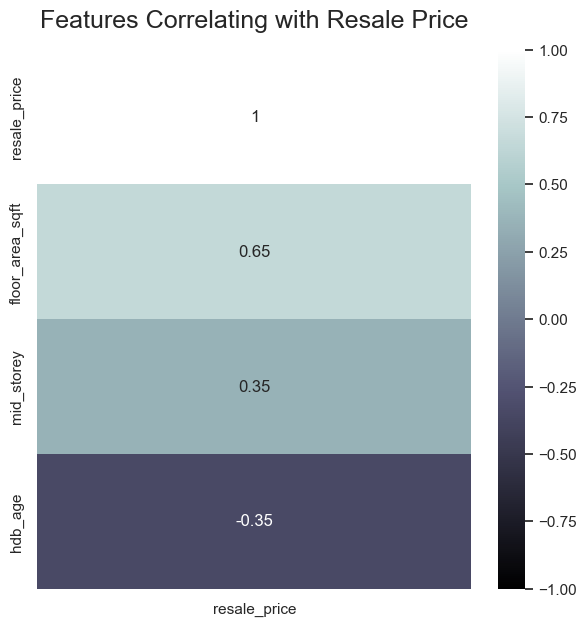

In [43]:
num_subset=train_df[['flat_type','floor_area_sqft','mid_storey','hdb_age','resale_price']]
heatmap = sns.heatmap(num_subset.corr(method='pearson')[['resale_price']].sort_values(by='resale_price', ascending=False), 
                      vmin=-1, vmax=1, annot=True, cmap='bone')
heatmap.set_title('Features Correlating with Resale Price', fontdict={'fontsize':18}, pad=16);

## 5A. I/O: Output prepped data

In [44]:
housing_df['flat_model']=housing_df['flat_model'].map(lambda x: x.lower())
housing_df['flat_type']=housing_df['flat_type'].map(lambda x: x.lower())

In [45]:
housing_df = pd.get_dummies(housing_df, columns=['region','flat_type','flat_model'], 
                   drop_first=True)

In [46]:
housing_df.head()

tranc_yearmonth    date_ym         town block         street_name storey_range  floor_area_sqm  lease_commence_date  tranc_year  tranc_month  mid_storey  lower  upper  mid   full_flat_type                address  floor_area_sqft  hdb_age  max_floor_lvl  year_completed  residential  commercial  market_hawker  multistorey_carpark  precinct_pavilion  total_dwelling_units  1room_sold  2room_sold  3room_sold  4room_sold  5room_sold  exec_sold  multigen_sold  studio_apartment_sold  1room_rental  2room_rental  3room_rental  other_room_rental  postal  latitude   longitude postal_2d  district_num planning_area  mall_nearest_distance  mall_within_500m  mall_within_1km  mall_within_2km  hawker_nearest_distance  hawker_within_500m  hawker_within_1km  hawker_within_2km  hawker_food_stalls  hawker_market_stalls  mrt_nearest_distance     mrt_name  bus_interchange  mrt_interchange  mrt_latitude  mrt_longitude  bus_stop_nearest_distance bus_stop_name  bus_stop_latitude  bus_stop_longitude  \
id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
1          2015-03 2015-03-01  BUKIT MERAH     7  TELOK BLANGAH CRES     07 TO 09            31.0                 1975        2015            3           8      7      9    8  1 ROOM Improved  7, TELOK BLANGAH CRES          333.684       46             12            1974            1           0              0                    0                  0                   262         255           0           2           0           0          0              0                      0             5             0             0                  0  090007  1.278361  103.819384        09             4   Bukit Merah            1246.092272               0.0              0.0              5.0               125.006922                 1.0                5.0               14.0                  56                    77           1180.622358  Tiong Bahru                0                0      1.285765     103.826997                  99.027522        Blk 11           1.277845          103.818658   
2          2015-04 2015-04-01  BUKIT MERAH     7  TELOK BLANGAH CRES     01 TO 03            31.0                 1975        2015            4           2      1      3    2  1 ROOM Improved  7, TELOK BLANGAH CRES          333.684       46             12            1974            1           0              0                    0                  0                   262         255           0           2           0           0          0              0                      0             5             0             0                  0  090007  1.278361  103.819384        09             4   Bukit Merah            1246.092272               0.0              0.0              5.0               125.006922                 1.0                5.0               14.0                  56                    77           1180.622358  Tiong Bahru                0                0      1.285765     103.826997                  99.027522        Blk 11           1.277845          103.818658   
3          2015-05 2015-05-01  

In [48]:
train_df = housing_df[housing_df['file']=='../datasets/train.csv'].drop(columns='file').copy(deep=True)
train_df.to_csv('../datasets/prepped_train.csv') 
test_df = housing_df[housing_df['file']=='../datasets/test.csv'].drop(columns='file').copy(deep=True)
test_df.to_csv('../datasets/prepped_test.csv') 

<u><b>Types of Flat Models:</b></u>

<u>Standard: (1/2/3/4/5-room)</u>: 1960s HDB. Had WC and shower in same room. 5-room Standard were introduced in 1974.<br>
<u>Improved: (1/2/3/4/5-room)</u>: Introduced in 1966, the 3/4-room having separate WC and shower, they also featured void decks. 5-room Improved were introduced in 1974.<br>
<u>New Generation</u>: Started first in 1975, New Generation flats can be 3-Room (67 / 82 sqm) or 4-Room (92 sqm), featuring en-suite toilet for master bedroom, with pedestal type Water Closet, plus store room.<br>
<u>Model A</u>: Introduced in 1981: 3-Room (75 sqm), 4-Room (105 sqm), 5-Room (135 sqm), 5-Room Maisonette (139 sqm)<br>
<u>Model A2</u>: Smaller units of Model A. e.g., 4-Room Model A2 (90 sqm)<br>
<u>Simplified</u>: Introduced in 1984: 3-Room (64 sqm), 4-Room (84 sqm)<br>
<u>Multi Generation</u>: 3Gen flats designed to meet the needs of multi-generation families.<br>
<u>Maisonette</u>: AKA Model A Maisonette — 2 storeys HDB flat<br>
<u>Premium Apartment</u>: Introduced somewhere during 1990s, featuring better quality finishes, you get them in ready-to-move condition, with flooring, kitchen cabinets, built-in wardrobes<br>
<u>Executive Maisonette</u>: More premium version of Model A Maisonettes. These units are no longer being built after being replaced by the Executive Condominium (EC) scheme in 1995<br>
<u>Executive Apartment</u>: Executive Apartment / Maisonette (146-150 sqm) were introduced in 1983 and replaced 5-Room Model A flats, in addition of the 3-bedroom and separate living/dining found in 5A flats, EA and EM feature an utility/maid room. 80% of Executive units were Maisonettes and 20% were Apartments.<br>
<u>DBBS</u>: public apartments built under the HDB's short-lived Design, Build and Sell Scheme (DBSS) from 2005 to 2012. They are a unique (and premium) breed of HDB flats in Singapore, which are built by private developers. High Prices. Quite similiar to Executive Condominium except DBBS is like a premium HDB without facilities of private condos<br>
<u>Adjoined Flat</u>: Large HDB flats which are combined from 2 HDB flats<br>
<u>Terrace</u>: HDB terrace flats built before HDB, without realizing Singapore's land constraint. Discontinued<br>
<u>Type S1 S2</u>: apartments at The Pinnacle@Duxton are classified as "S" or Special apartments in view of its historical significance and award-winning design. For application of HDB policies, S1 and S2 apartments will be treated as 4-room and 5-room flats respectively<br>
<u>2-room</u>: Most likely refers to 2-room flexi where there is 1 bedroom and 1 common area<br>